In [26]:
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import skimage.transform
import imageio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [27]:
path = r"C:\Users\owais akmad khan\OneDrive\Desktop\project\archive_Copy\\"
files = np.array(pd.read_csv(r"C:\Users\owais akmad khan\OneDrive\Desktop\project\archive_Copy\files.csv"))

selected_indices = np.random.choice(len(files), int(0.56 * len(files)), replace=False)
selected_files = files[selected_indices, 0]

files_train, files_valid, cls_train, cls_valid = train_test_split(
    selected_files, files[selected_indices, 1], test_size=0.2, random_state=40
)

print(files_train.shape, files_valid.shape)
cls_train = to_categorical(cls_train, 205, dtype='int')
cls_valid = to_categorical(cls_valid, 205, dtype='int')


(106684,) (26672,)


In [4]:
def load_image(file_path):
    img = imageio.imread(file_path)
    img = skimage.color.rgb2lab(img)
    img = skimage.transform.resize(img, (256, 256))
    gray = img[:,:,0].reshape((256, 256, 1))
    color = img[:,:,1:].reshape((256, 256, 2))
    return gray, color


In [5]:
def batch_generator(for_train, batch_size, files, cls, path):
    while True:
        if for_train:
            idx = np.random.randint(0, files.shape[0], batch_size)
        else:
            idx = np.random.randint(0, files.shape[0], batch_size)

        gray = np.zeros((batch_size, 256, 256, 1))
        colo = np.zeros((batch_size, 256, 256, 2))
        cls_batch = np.zeros((batch_size, 205))

        for i in range(batch_size):
            gray[i], colo[i] = load_image(os.path.join(path, files[idx[i]]))
            cls_batch[i, :] = cls[idx[i]]

        gray = gray / 100
        colo = (colo + 128) / 255
        yield gray, [cls_batch, colo]



In [6]:
gray_image = Input(shape=(256, 256, 1))

In [7]:

conv = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(gray_image))
low_glo = BatchNormalization()(conv(gray_image))

conv = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))

conv = Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))

conv = Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))

conv = Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))

conv = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')
low_mid = BatchNormalization()(conv(low_mid))
low_glo = BatchNormalization()(conv(low_glo))



In [8]:
low_mid = Dropout(0.5)(low_mid)

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
glo = Conv2D(512, (3, 3), strides=(2, 2), padding='same', activation='tanh')(low_glo)
glo = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(glo)
glo = Conv2D(512, (3, 3), strides=(2, 2), padding='same', activation='tanh')(glo)
glo = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(glo)
glo = Flatten()(glo)
glo = Dense(1024, activation='tanh')(glo)
glo_512 = Dense(512, activation='tanh')(glo)
glo = Dense(256, activation='tanh')(glo_512)
print(glo)

KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='dense_2/Tanh:0', description="created by layer 'dense_2'")


In [11]:
cls = Dense(256, activation='tanh')(glo_512)
cls = Dense(205, activation='softmax')(cls)

In [12]:
mid = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_mid)
mid = Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='tanh')(mid)
print(mid)  

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='conv2d_11/Tanh:0', description="created by layer 'conv2d_11'")


In [13]:
print(mid)
print(glo)

fused = Reshape((1, 1, 256))(glo)
fused = Lambda(lambda x: tf.tile(x, (1, 32, 32, 1)))(fused)
fused = concatenate([mid, fused], 3)
fused = Dense(256, activation='tanh')(fused)
print(fused)

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='conv2d_11/Tanh:0', description="created by layer 'conv2d_11'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='dense_2/Tanh:0', description="created by layer 'dense_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 256), dtype=tf.float32, name=None), name='dense_5/Tanh:0', description="created by layer 'dense_5'")


In [14]:
colo = Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='tanh')(fused)
colo = UpSampling2D((2, 2))(colo)
colo = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='tanh')(colo)
colo = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='tanh')(colo)
colo = UpSampling2D((2, 2))(colo)
colo = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='tanh')(colo)
output = Conv2D(2, (3, 3), strides=(1, 1), padding='same', activation='sigmoid')(colo)
output = UpSampling2D((2, 2))(output)
print(output)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None), name='up_sampling2d_2/resize/ResizeNearestNeighbor:0', description="created by layer 'up_sampling2d_2'")


In [15]:
conv = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_mid)
low_mid = BatchNormalization()(conv)
low_mid = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_mid)
low_mid = BatchNormalization()(low_mid)

conv = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_glo)
low_glo = BatchNormalization()(conv)
low_glo = Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='tanh')(low_glo)
low_glo = BatchNormalization()(low_glo)

In [17]:
model = Model(inputs=gray_image, outputs=[cls, output])
model.compile(optimizer = "adam", loss = ["categorical_crossentropy", "mse"])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     


 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]',                
                                )                                 'input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 128, 128, 64  256        ['conv2d[1][0]']                 
 rmalization)                   )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 12  73856       ['batch_normalization[0][0]',    
          

In [18]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss=["categorical_crossentropy", "mse"])

c:\Users\owais akmad khan\.conda\envs\owais\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
batch_size = 8

train_gen = batch_generator(True, batch_size=batch_size, files=files_train, cls=cls_train, path=path)
valid_gen = batch_generator(False, batch_size=batch_size, files=files_valid, cls=cls_valid, path=path)


In [20]:
callbacks = [
    ModelCheckpoint('imageio_model.h5', save_best_only=True),
    EarlyStopping(patience=5, restore_best_weights=True)
]

In [21]:
history = model.fit(
    x=train_gen,
    epochs=6,
    steps_per_epoch=files_train.shape[0] // (batch_size // 2),
    validation_data=valid_gen,
    validation_steps=files_valid.shape[0] // (batch_size // 2),
    callbacks=callbacks
)

C:\Users\owais akmad khan\AppData\Local\Temp\ipykernel_8424\3646793123.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(file_path)


Epoch 1/6
21908/21908 [==============================] - 8756s 399ms/step - loss: 5.2002 - dense_4_loss: 5.1970 - up_sampling2d_2_loss: 0.0032 - val_loss: 5.1678 - val_dense_4_loss: 5.1648 - val_up_sampling2d_2_loss: 0.0030
Epoch 2/6
21908/21908 [==============================] - 8755s 400ms/step - loss: 4.8609 - dense_4_loss: 4.8580 - up_sampling2d_2_loss: 0.0029 - val_loss: 4.5878 - val_dense_4_loss: 4.5851 - val_up_sampling2d_2_loss: 0.0027
Epoch 3/6
21908/21908 [==============================] - 9210s 420ms/step - loss: 4.4032 - dense_4_loss: 4.4005 - up_sampling2d_2_loss: 0.0027 - val_loss: 4.3772 - val_dense_4_loss: 4.3746 - val_up_sampling2d_2_loss: 0.0026
Epoch 4/6
21908/21908 [==============================] - 9907s 452ms/step - loss: 4.1775 - dense_4_loss: 4.1749 - up_sampling2d_2_loss: 0.0026 - val_loss: 4.2478 - val_dense_4_loss: 4.2452 - val_up_sampling2d_2_loss: 0.0026
Epoch 5/6
21908/21908 [==============================] - 8647s 395ms/step - loss: 4.0276 - dense_4_loss:

In [23]:
def colorize(orig, resized):
    predicted = model.predict(resized)[1]
    resized = np.concatenate((resized, predicted), axis=3)

    for pos in range(resized.shape[0]):
        resized[pos,:,:,0] = resized[pos,:,:,0]*100
        resized[pos,:,:,1:] = resized[pos,:,:,1:]*255 - 128
        resized[pos] = skimage.color.lab2rgb(resized[pos])

        temp = skimage.color.rgb2gray(orig[pos])
        skimage.io.imshow(orig[pos])
        plt.show()

        final_image = skimage.transform.resize(resized[pos], orig[pos].shape)
        skimage.io.imshow(final_image)
        plt.show()

C:\Users\owais akmad khan\AppData\Local\Temp\ipykernel_8424\3568401826.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  orig.append(imageio.imread(img_path))


1/1 [==============================] - 2s 2s/step


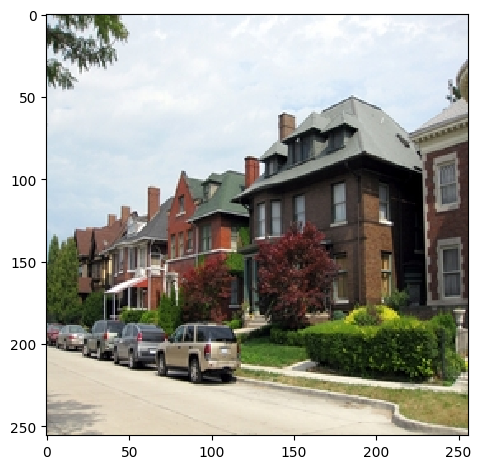

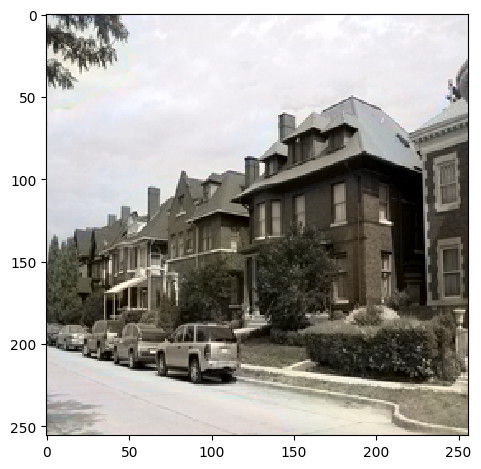

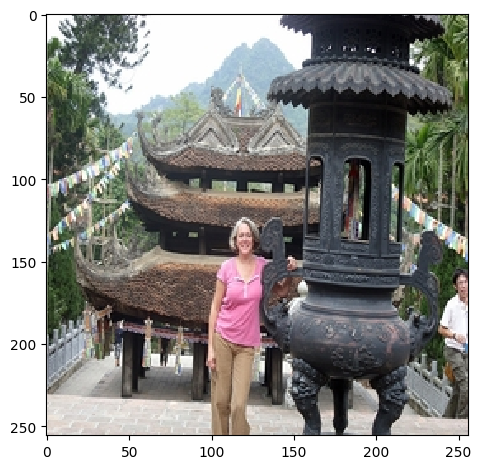

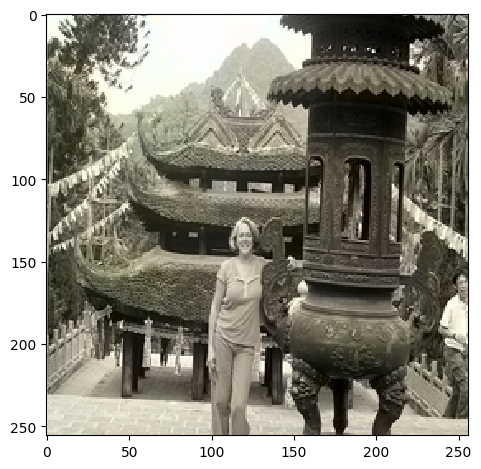

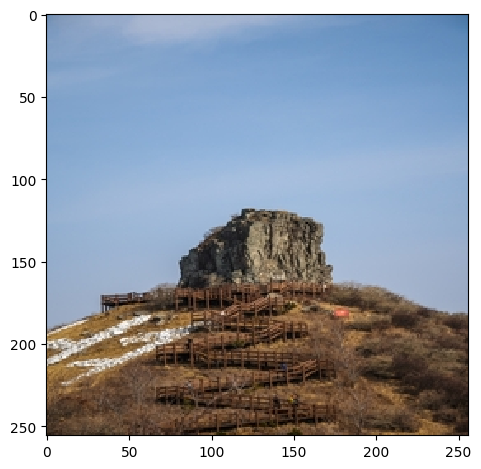

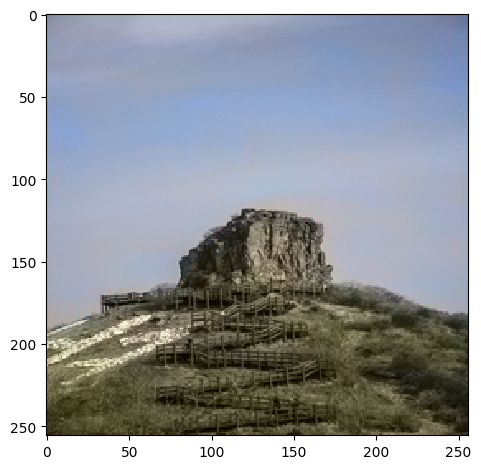

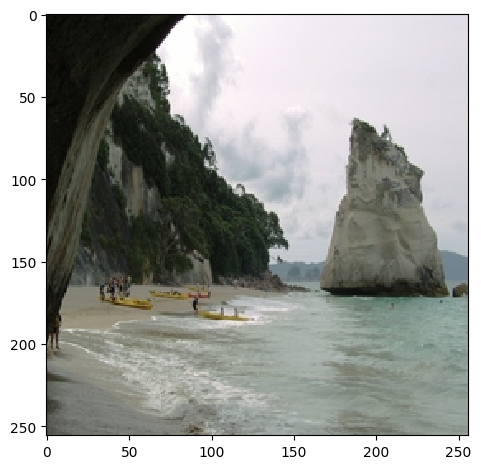

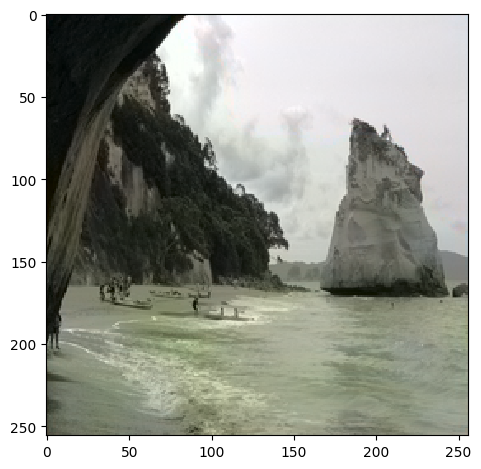

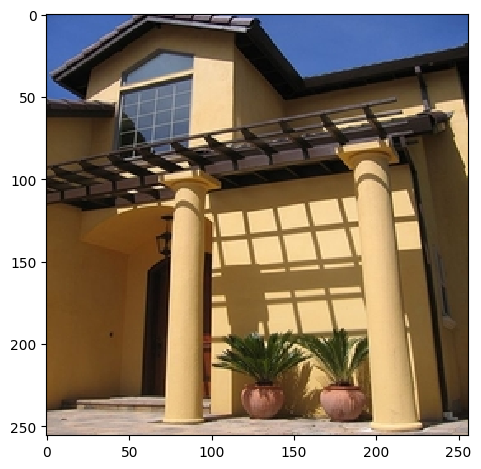

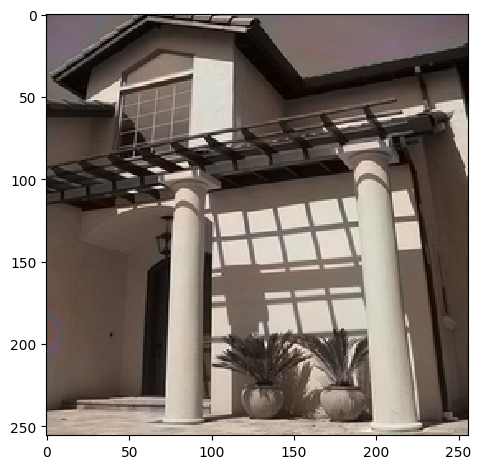

In [24]:
files = files_train
orig = []
num = 5
resized = np.zeros((num, 256, 256, 1))
for pos in range(num):
    img_path = os.path.join(path, files[pos]) 
    orig.append(imageio.imread(img_path))  
    temp = skimage.transform.resize(orig[pos], (256, 256))
    if temp.shape == (256, 256, 3):
        temp = skimage.color.rgb2lab(temp)[:,:,0]
        temp = temp/100
    if temp.shape == (256, 256, 1):
        resized[pos] = temp
    else:
        resized[pos,:,:,0] = temp
colorize(orig, resized)

C:\Users\owais akmad khan\AppData\Local\Temp\ipykernel_8424\478161961.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  orig.append(imageio.imread(img_path))


1/1 [==============================] - 0s 251ms/step


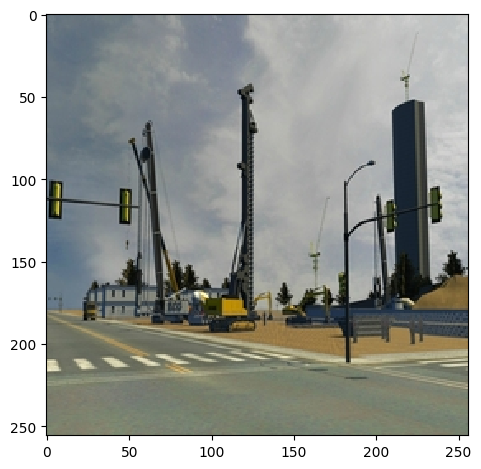

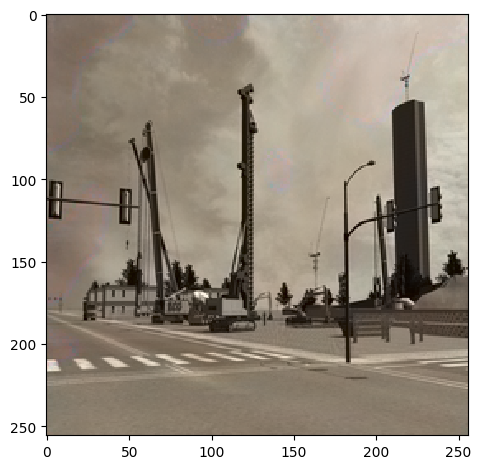

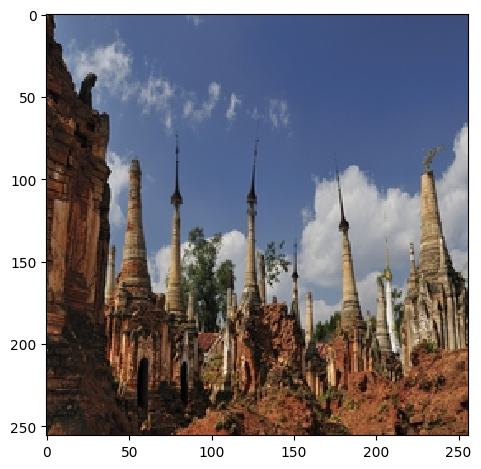

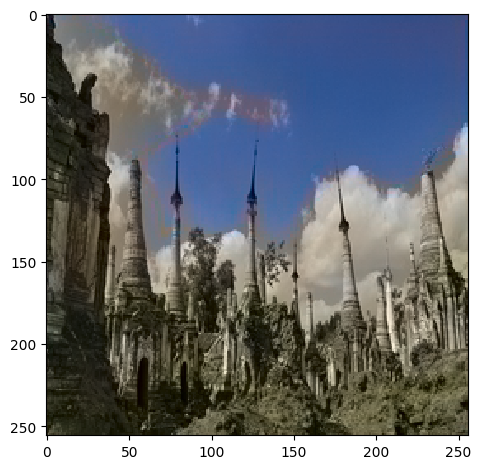

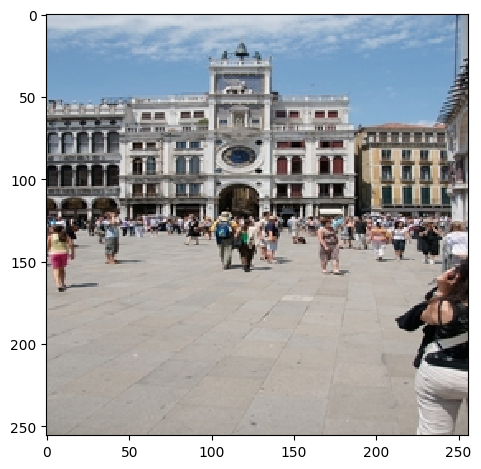

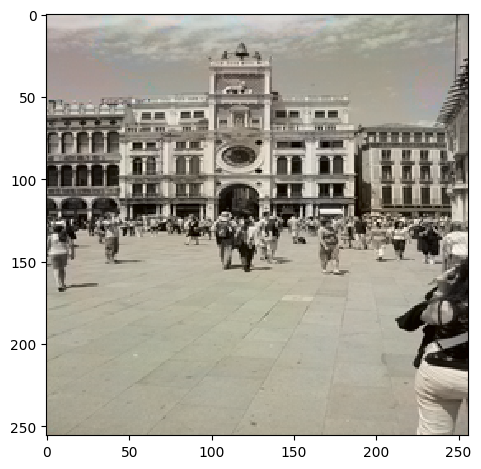

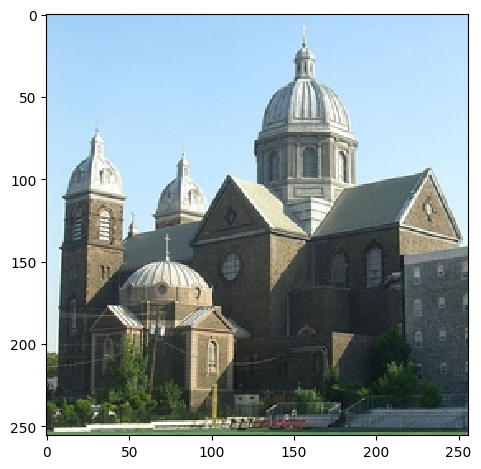

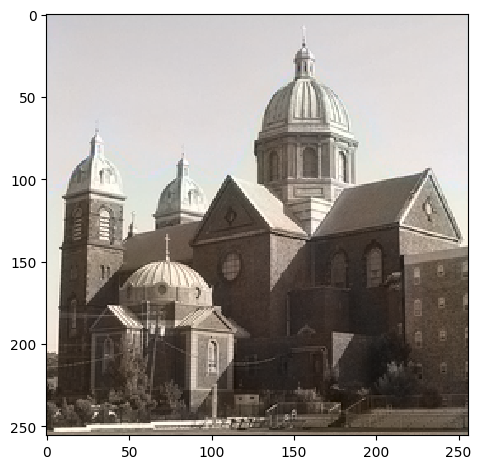

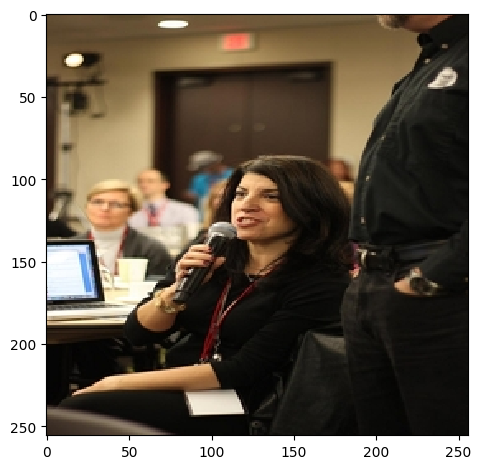

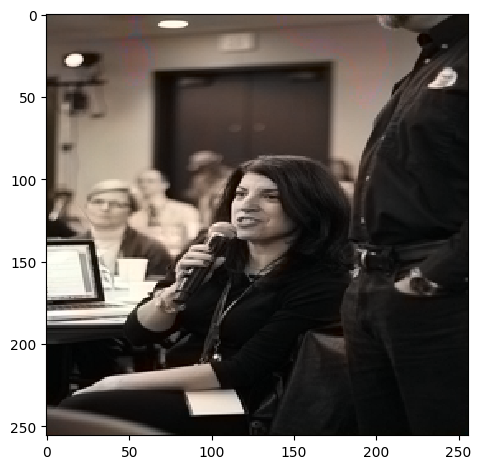

In [25]:
files = files_valid
orig = []
num = 5
resized = np.zeros((num, 256, 256, 1))
for pos in range(num):
    img_path = os.path.join(path, files[pos]) 
    orig.append(imageio.imread(img_path))
    temp = skimage.transform.resize(orig[pos], (256, 256))
    if temp.shape == (256, 256, 3):
        temp = skimage.color.rgb2lab(temp)[:,:,0]
        temp = temp/100
    if temp.shape == (256, 256, 1):
        resized[pos] = temp
    else:
        resized[pos,:,:,0] = temp
colorize(orig, resized)